In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as Data
import torchvision.transforms as transforms

import torch.optim as optim
import time


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Downloading Data

In [5]:
!wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

--2020-12-28 08:45:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  96.3MB/s    in 1.7s    

2020-12-28 08:45:48 (96.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [6]:
!tar xvzf "./cifar-10-python.tar.gz"

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


###Loading Data

 In the following, I will use the code in the given link in excersie 4.

In [7]:
def load_cifar10_data(filename):
    with open('./cifar-10-batches-py/'+ filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data']
    labels = batch['labels']
    return features, labels

In [8]:
# Load files
batch_1, labels_1 = load_cifar10_data('data_batch_1')
batch_2, labels_2 = load_cifar10_data('data_batch_2')
batch_3, labels_3 = load_cifar10_data('data_batch_3')
batch_4, labels_4 = load_cifar10_data('data_batch_4')
batch_5, labels_5 = load_cifar10_data('data_batch_5')

test, label_test = load_cifar10_data('test_batch')

In [9]:
# Merge files
X_train = np.concatenate([batch_1,batch_2,batch_3,batch_4,batch_5], 0)
Y_train = np.concatenate([labels_1,labels_2,labels_3,labels_4,labels_5], 0)

In [10]:
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def return_photo(batch_file):
    assert batch_file.shape[1] == 3072
    dim = np.sqrt(1024).astype(int)
    r = batch_file[:, 0:1024].reshape(batch_file.shape[0], dim, dim, 1)
    g = batch_file[:, 1024:2048].reshape(batch_file.shape[0], dim, dim, 1)
    b = batch_file[:, 2048:3072].reshape(batch_file.shape[0], dim, dim, 1)
    photo = np.concatenate([r,g,b], -1)
    return photo

In [11]:
X_train = return_photo(X_train)
X_test = return_photo(test)
Y_test = np.array(label_test)

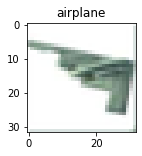

In [12]:
def plot_image(number, file, label, pred=None):
    fig = plt.figure(figsize = (3,2))
    #img = return_photo(batch_file)
    plt.imshow(file[number])
    if pred is None:
        plt.title(classes[label[number]])
    else:
        plt.title('Label_true: ' + classes[label[number]] + '\nLabel_pred: ' + classes[pred[number]])
    
plot_image(12345, X_train, Y_train)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64


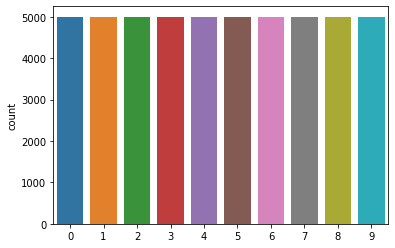

In [13]:
# The cifar-10 is designed to balance distribution that the counts for each classification are 5000
import seaborn as sns
sns.countplot(Y_train)
hist_Y_train = pd.Series(Y_train).groupby(Y_train).count()
print(hist_Y_train)

### Preprocessing Data

In [14]:
# Final check for dimensions before pre-pocessing
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000,)


In [15]:
# split the validation set out
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

In [16]:
### Prepare for training & testing dataset. Define dataset class.
import torch
import torchvision.transforms as transforms
import random
from torch.utils.data import Dataset
from PIL import Image

# define the random seed for reproducible result
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Dataset
class CIFAR10_from_array(Dataset): 
    def __init__(self, data, label, transform=None):
        ### Initialize paths, transforms, and so on
        #self.data = torch.from_numpy(data).float()
        #self.label = torch.from_numpy(label).long()
        self.data = data
        self.label = label
        self.transform = transform
        self.img_shape = data.shape
        
    def __getitem__(self, index):
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        
        img = Image.fromarray(self.data[index])
        label = self.label[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img_to_tensor = transforms.ToTensor()
            img = img_to_tensor(img)
            #label = torch.from_numpy(label).long()
        return img, label
        
    def __len__(self):
        # Indicate the total size of the dataset
        return len(self.data)
    
    def plot_image(self, number):
        file = self.data
        label = self.label
        fig = plt.figure(figsize = (3,2))
        #img = return_photo(batch_file)
        plt.imshow(file[number])
        plt.title(classes[label[number]])

In [17]:
# Normalize for R, G, B with img = img - mean / std
def normalize_dataset(data):
    mean = data.mean(axis=(0,1,2)) / 255.0
    std = data.std(axis=(0,1,2)) / 255.0
    normalize = transforms.Normalize(mean=mean, std=std)
    return normalize


# apply transforms to return img as tensor type
# Notice that the order in the "compose" does matter
train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),  
    transforms.RandomCrop((32, 32)),   
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

# Also use X_train in normalize since train/val sets should have same distribution
val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_test)
])

trainset = CIFAR10_from_array(data=X_train_split, label=Y_train_split, transform=train_transform_aug)
valset = CIFAR10_from_array(data=X_val_split, label=Y_val_split, transform=val_transform)
testset = CIFAR10_from_array(data=X_test, label=Y_test, transform=test_transform)

In [18]:
print('data shape check')
print('training set:'.ljust(20) + '{}'.format(trainset.img_shape))
print('validation set:'.ljust(20) + '{}'.format(valset.img_shape))
print('testing set:'.ljust(20) + '{}'.format(testset.img_shape))
print('label numbers:'.ljust(20) + '{}'.format(len(set(trainset.label))))

data shape check
training set:       (40000, 32, 32, 3)
validation set:     (10000, 32, 32, 3)
testing set:        (10000, 32, 32, 3)
label numbers:      10


In [19]:
# put into the data loader
from torch.utils.data import DataLoader

batch_size = 64
num_workers = 1

train_loader = DataLoader(dataset=trainset,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=num_workers)


val_loader = DataLoader(dataset=valset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)

test_loader = DataLoader(dataset=testset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)


In [20]:
imgs, lbls = iter(train_loader).next()
print ('Size of image:', imgs.size())  # batch_size*3*224*224
print ('Type of image:', imgs.dtype)   # float32
print ('Size of label:', lbls.size())  # batch_size
print ('Type of label:', lbls.dtype)   # int64(long)

Size of image: torch.Size([64, 3, 32, 32])
Type of image: torch.float32
Size of label: torch.Size([64])
Type of label: torch.int64


### Model with Dropout

In [21]:
# Build the CNN
class Net_dropout(nn.Module):
    def __init__(self, dropout=0.2, batch_norm=False):
        super(Net_dropout, self).__init__()
        self.batch_norm=batch_norm
        # if batch_norm==True we add a batch normalization layer after second convolution layer and before dropout
        if batch_norm==True:
            self.batch_norm = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        #3*32*32 -> 32*32*32
        self.dropout1 = nn.Dropout(p=dropout)        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #32*32*32 -> 16*16*32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        #16*16*32 -> 16*16*64
        self.dropout2 = nn.Dropout(p=dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #16*16*64 -> 8*8*64
        self.fc1 = nn.Linear(8*8*64, 1024)
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout4 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(512, 10)
            

    def forward(self, x):
        x = self.dropout1(self.conv1(x))
        x = self.pool1(F.relu(x))
        x = self.dropout2(self.conv2(x))
        if self.batch_norm==True:
            x=self.batch_norm(x)
        x = self.pool2(F.relu(x))
        x = x.view(-1, self.num_flat_features(x)) 
        #self.num_flat_features(x) = 8*8*64 here.
        #-1 means: get the rest a row (in this case is 16 mini-batches)
        #pytorch nn only takes mini-batch as the input
        
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


        
#display net architecture
print(Net_dropout())  

Net_dropout(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


### Training process

In [22]:
def update_info(idx, length, epoch_loss, acc, mode):
    
    if length >= 250:
        update_size = int(length/250)
    else:
        update_size = 5
    
    if idx % update_size == 0 and idx != 0:
        #print ('=', end="")        
        finish_rate = idx/length * 100
        print ("\r   {} progress: {:.2f}%  ......  loss: {:.4f} , acc: {:.4f}".
               format(mode, finish_rate, epoch_loss/idx, acc), end="", flush=True)
        

def val_per_epoch(model, loss_fn, dataloader, verbose):
    # In validation, we only compute loss value
    model.eval()
    epoch_loss = 0.0
    acc = 0.0
    val_size = 0
    with torch.no_grad(): 
        for i, (feature, target) in enumerate(dataloader):
            
            #feature, target = feature.to(device), target.to(device)
            if torch.cuda.is_available():
                feature = feature.cuda()
                target = target.cuda()
            
            output = model(feature) #outputs.data.shape= batches_num * num_class
            
            #compute acc
            _, pred = torch.max(output.data, dim=1) 
            correct = (pred == target).sum().item() #convert to number
            val_size += target.size(0)
            acc += correct
            
            
            loss = loss_fn(output, target)
            epoch_loss += loss.item()
            
            
            idx = i
            length = len(dataloader)
            
            #display progress
            if verbose:
                update_info(idx, length, epoch_loss, acc/val_size, 'validating')
                
        acc = acc/val_size
    print('')
    return epoch_loss/len(dataloader), acc

In [30]:
def visualize_tensor(tensor, nrows, ncols, ch=0, RGB=False, padding=1): 
        # print('tensor shape', tensor.shape) # [num_filters, depth, kernel_size, kernel_size]

        n,c,w,h = tensor.shape
        if RGB==False: tensor = tensor.view(n*c, -1, w, h)

        grid = torchvision.utils.make_grid(tensor, ncols, normalize=True, padding=padding)
        plt.figure( figsize=(nrows,ncols) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

In [31]:
def train_per_epoch(model, loss_fn, dataloader, optimizer, verbose): 
    #train mode
    model.train()
    
    #initialize loss
    epoch_loss = 0.0
    acc = 0.0
    train_size = 0
    
    for i, (feature, target) in enumerate(dataloader):
        #feature, target = feature.to(device), target.to(device)
        
        if torch.cuda.is_available():
            feature = feature.cuda()
            target = target.cuda()
        
        #set zero to the parameter gradients for initialization
        optimizer.zero_grad()
        output = model(feature)
        loss = loss_fn(output, target)
        
        
        #compute acc
        _, pred = torch.max(output.data, dim=1) 
        correct = (pred == target).sum().item() #convert to number
        train_size += target.size(0)
        acc += correct
        
        #compute current loss. Loss is a 0-dim tensor, so use tensor.item() to get the scalar value
        epoch_loss += loss.item()  
        
        #backward propagation
        loss.backward()
        
        #this represents one update on the weight/bias for a mini-batch(16 images in our case): 
        #weights[k] + alpha * d_weights[k]
        optimizer.step()
        
        #show the update information
        idx = i
        length = len(dataloader)
        
        #display progress
        if verbose:
            update_info(idx, length, epoch_loss, acc/train_size, '  training')
            
    acc = acc/train_size
    print('') 
    return epoch_loss/len(dataloader), acc


In [38]:
def model_training(num_epochs, model, loss_fn, train_loader, optimizer, val_loader=None, verbose=True, visualization=False):
    
    train_batch_num = len(train_loader)
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_acc'] = []
    history['val_acc'] = []
    
    if val_loader is not None:
        
        val_batch_num = len(val_loader)
        
        print('Total Sample: Train on {} samples, validate on {} samples.'.
             format(trainset.img_shape[0], valset.img_shape[0]))
        
        print(' Total Batch: Train on {} batches, validate on {} batches. {} samples/minibatch \n'.
         format(train_batch_num, val_batch_num, batch_size))
    
    else:
        print('Total Sample: Train on {} samples.'.
             format(train_batch_num*batch_size))
        
        print(' Total Batch: Train on {} batches, {} samples/minibatch \n'.
         format(train_batch_num, batch_size))
    
    
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_per_epoch(model, loss_fn, train_loader, optimizer, verbose=verbose)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        
        if val_loader is not None:
            val_loss, val_acc = val_per_epoch(model, loss_fn, val_loader, verbose=verbose)
            if (epoch+1)==1 or (epoch+1)==20:
                print('Epoch {}/{}'.format(epoch+1, num_epochs))
                print('\n        Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(train_loss,val_loss))
                print('         Training acc: {:.4f},  Validation acc: {:.4f}\n'.format(train_acc,val_acc))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
                        
        else:
            
            print('\n        Training Loss: {:.4f}\n'.format(train_loss))
            print('\n         Training acc: {:.4f}\n'.format(train_acc))
        
        if visualization==True:
            # visualize filters of conv layers 1 and 2
            # layer 1 filters are 3*5*5 so they can be visualized as RGB photos
            # layer 2 filters are 64 filters each with depth 32 and kernel size 3
            if (epoch+1)==1 or (epoch+1)==20:
                visualize_tensor(model.conv1.weight.detach(),nrows=4,ncols=8, RGB=True)
                visualize_tensor(model.conv2.weight.detach(), nrows=64, ncols=32)

    
    return history


### RMSprop optimizer

In [ ]:
num_epochs = 20
learning_rate = 0.001
net = Net_dropout()

if torch.cuda.is_available():
    net = net.cuda()
print(net)
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate) #optimizer
#training and validating
hist_RMSprop = model_training(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True)

In [ ]:
def hist_save(name, history):
    addrs='/content/drive/My Drive/MLSec/hw2/q4/history_'+name+'.pickle'
    with open(addrs, 'wb') as pkl:
        pickle.dump(history, pkl,protocol=pickle.HIGHEST_PROTOCOL)

hist_save('RMSprop',hist_RMSprop)
torch.save(net.state_dict(), '/content/drive/My Drive/MLSec/hw2/q4/model_RMSprop')

### Adam optimizer + visualizing filters

Net_dropout(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)
Total Sample: Train on 40000 samples, validate on 10000 samples.
 Total Batch: Train on 625 batches, validate on 157 batches. 64 samples/minibatch 

     training progress: 99.84%  ......  loss: 1.6433 , acc: 0.3998
   validating progress: 98.73%  ......  loss: 1.4185 , acc: 0.4976
Epo

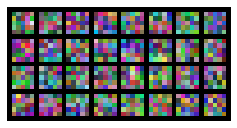

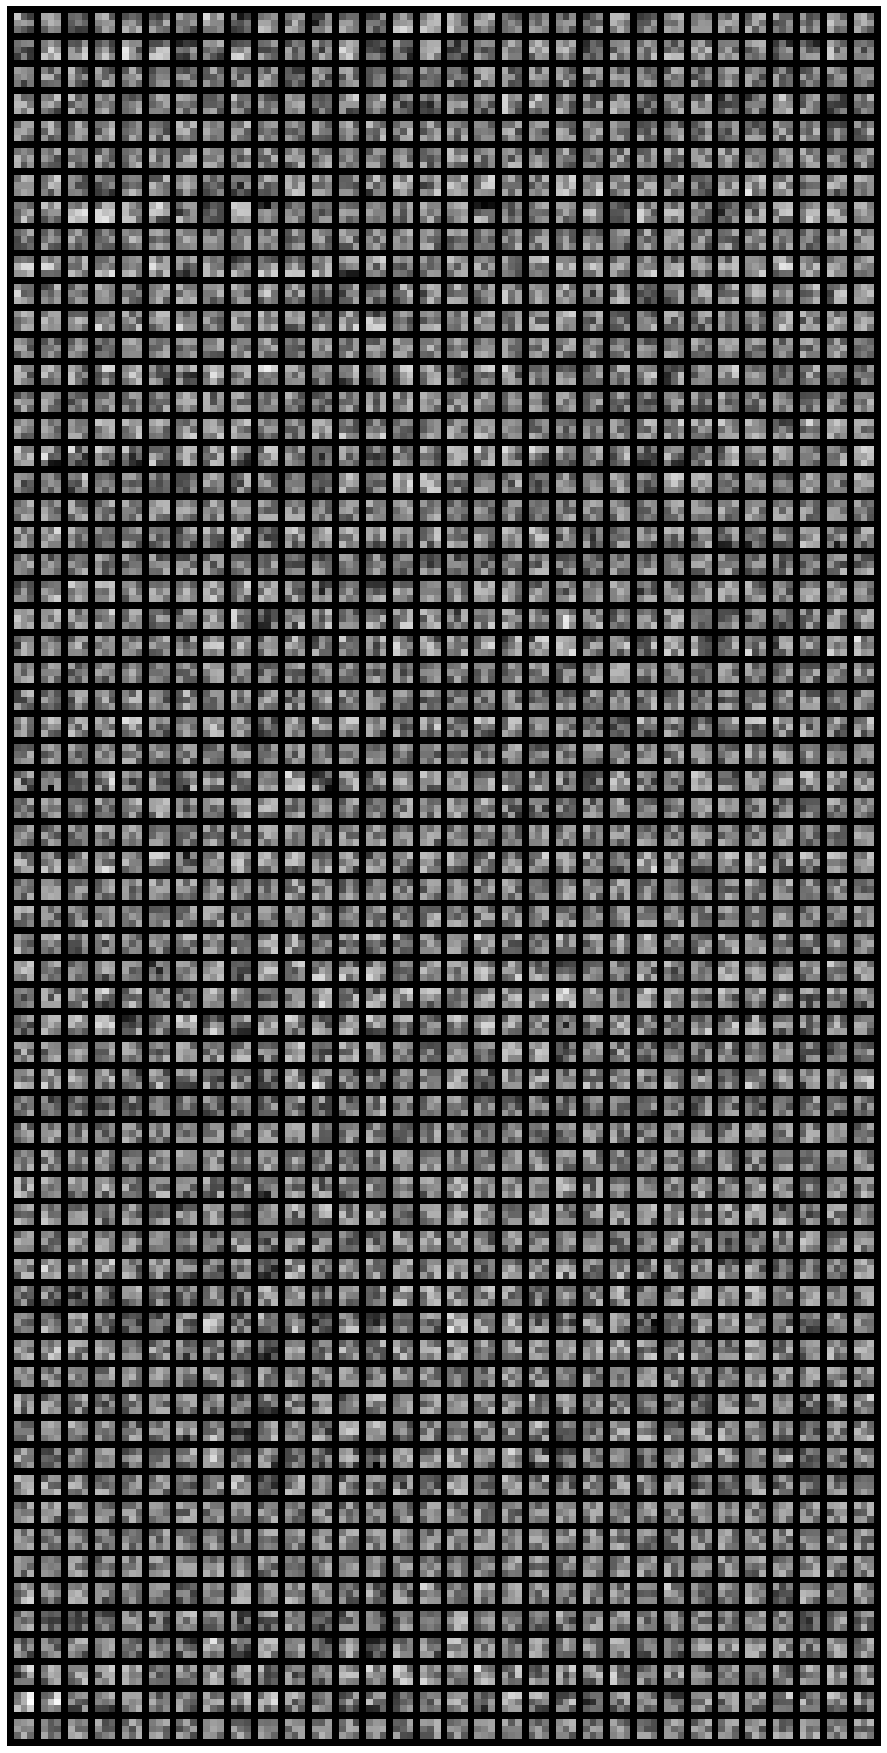

     training progress: 99.84%  ......  loss: 1.3796 , acc: 0.5061
   validating progress: 98.73%  ......  loss: 1.2405 , acc: 0.5565
     training progress: 99.84%  ......  loss: 1.2627 , acc: 0.5524
   validating progress: 98.73%  ......  loss: 1.1721 , acc: 0.5860
     training progress: 99.84%  ......  loss: 1.1840 , acc: 0.5821
   validating progress: 98.73%  ......  loss: 1.1014 , acc: 0.6151
     training progress: 99.84%  ......  loss: 1.1399 , acc: 0.5979
   validating progress: 98.73%  ......  loss: 1.0902 , acc: 0.6183
     training progress: 99.84%  ......  loss: 1.0892 , acc: 0.6155
   validating progress: 98.73%  ......  loss: 1.0400 , acc: 0.6316
     training progress: 99.84%  ......  loss: 1.0561 , acc: 0.6302
   validating progress: 98.73%  ......  loss: 0.9717 , acc: 0.6691
     training progress: 99.84%  ......  loss: 1.0367 , acc: 0.6348
   validating progress: 98.73%  ......  loss: 1.0044 , acc: 0.6501
     training progress: 99.84%  ......  loss: 1.0160 , acc: 0.

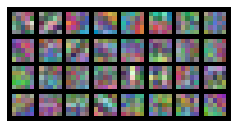

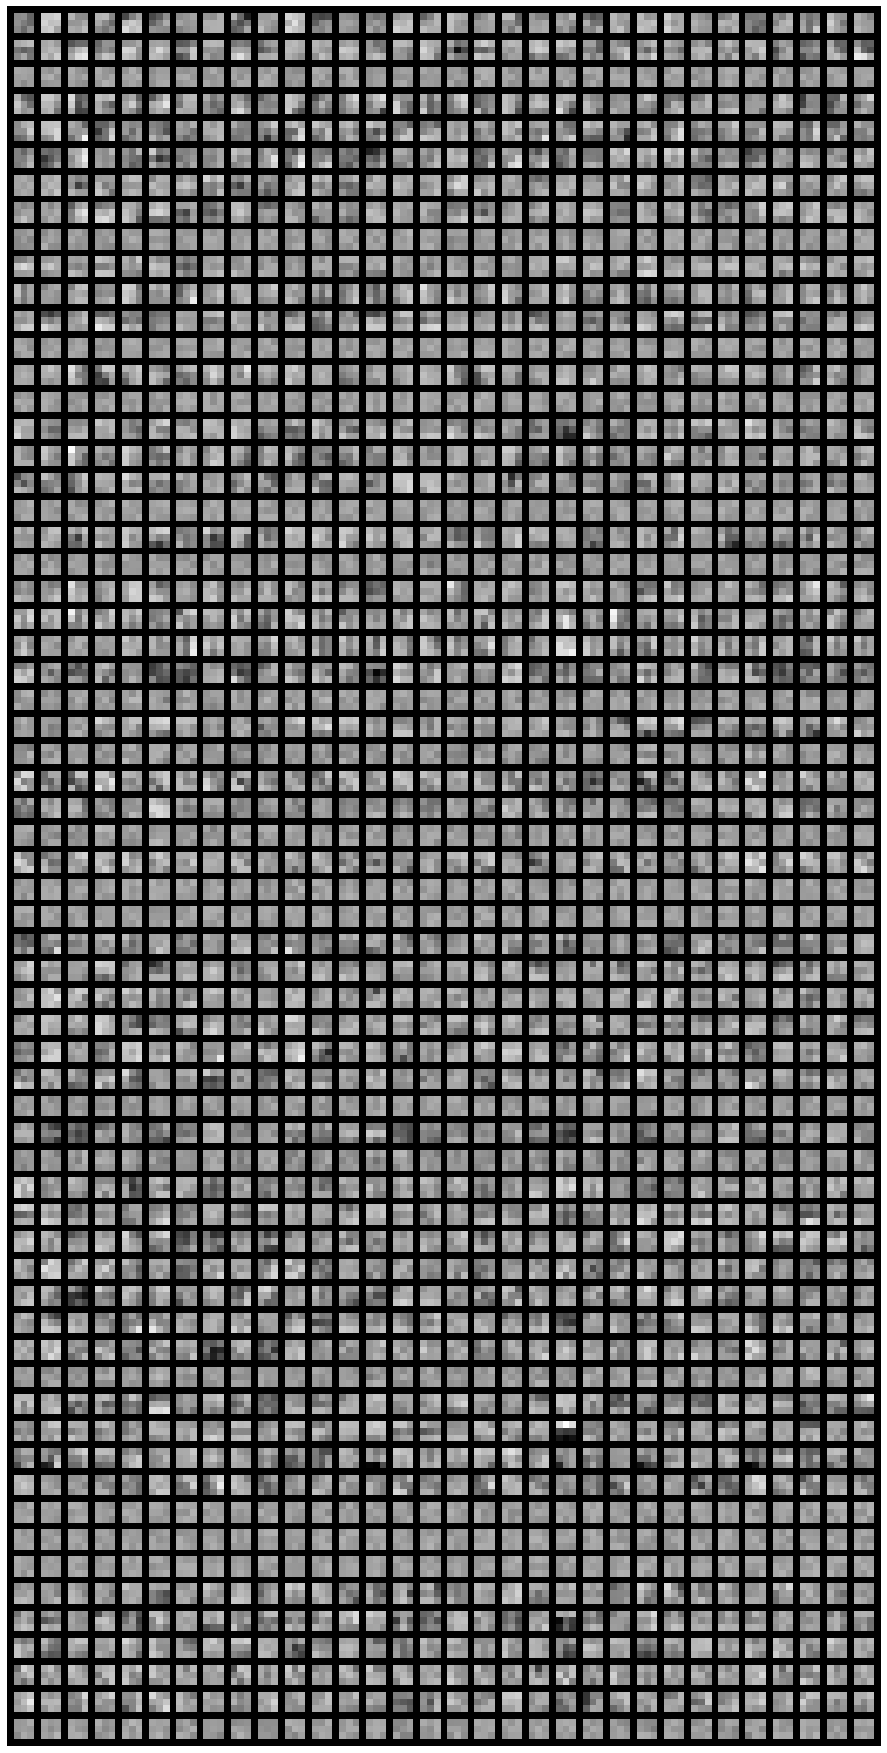

In [39]:
num_epochs = 20
learning_rate = 0.001
net = Net_dropout(0.2)

if torch.cuda.is_available():
    net = net.cuda()
print(net)
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #optimizer
#training and validating, here we set visualization=True
hist_adam = model_training(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True, visualization=True)


In [ ]:
hist_save('adam', hist_adam) # history_adam file 
torch.save(net.state_dict(), '/content/drive/My Drive/MLSec/hw2/q4/model_adam')

Part 3 a:

Those filters that operate directly on the raw pixel (weights of the first conv layer) will learn to extract low-level features, such as lines and edges. The filters that operate on the output of the first layers (weights of higher conv layers) may extract features that are combinations of lower-level features, such as features that comprise multiple lines to express shapes, and in the last layers they might extract some parts of the image.

However, the number of conv layers and kernel sizes of filters are small in this example and it is hard to see these patterns well.

---



Part 2 : Adam uses the idea of RMSprop and Momentum together which results in an improvement in its convergence rate. The picture below (copied from lecture slides), shows the update rule of Adam and how RMSprop and Momentum are used in it: 
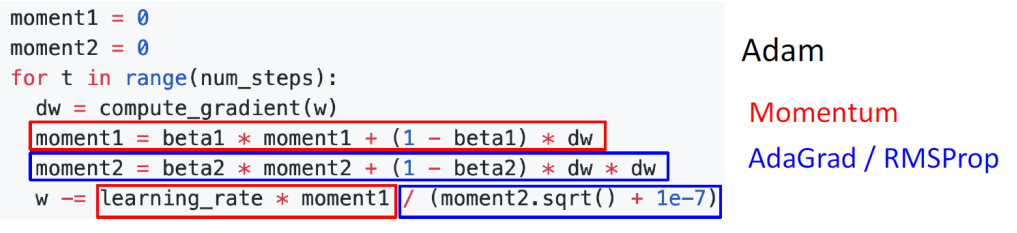

### Comparing the results of training using Adam and RMSprop as optimizers

In [ ]:
def hist_plot(history):
    plt.plot(np.arange(num_epochs)+1,history['train_loss'],label='train_loss')
    plt.plot(np.arange(num_epochs)+1,history['val_loss'],label='val_loss')
    plt.legend()
    plt.show()

    plt.plot(np.arange(num_epochs)+1,history['train_acc'],label='train_acc')
    plt.plot(np.arange(num_epochs)+1,history['val_acc'],label='val_acc')
    plt.legend()
    plt.show()   

def compare(history1, history2, name1, name2):
    plt.plot(np.arange(num_epochs)+1,history1['train_loss'],label=name1)
    plt.plot(np.arange(num_epochs)+1,history2['train_loss'],label=name2)
    plt.legend()
    plt.show()

    plt.plot(np.arange(num_epochs)+1,history1['train_acc'],label=name1)
    plt.plot(np.arange(num_epochs)+1,history2['train_acc'],label=name2)
    plt.legend()
    plt.show() 

RMSprop:


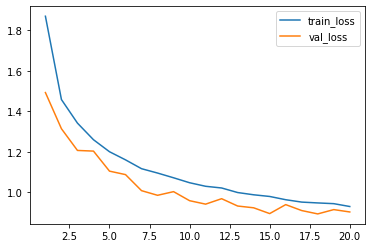

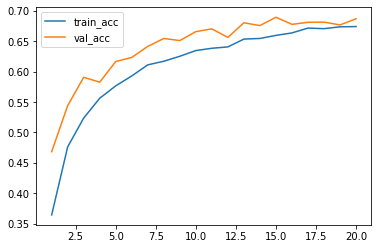

Adam:


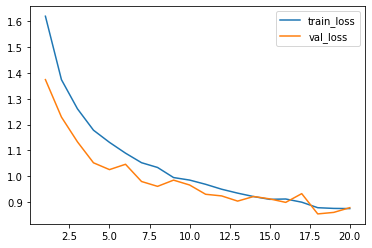

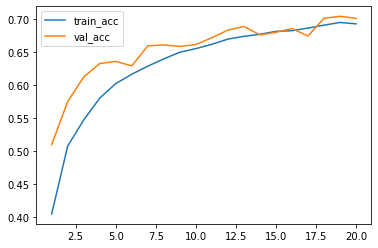

compare


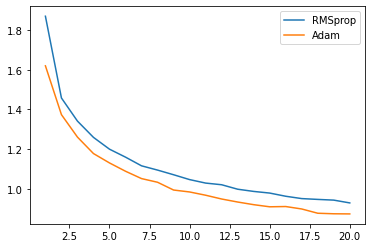

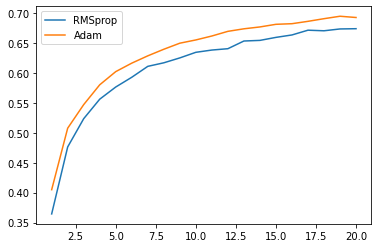

In [ ]:
print('RMSprop:')
with open('/content/drive/My Drive/MLSec/hw2/q4/history_RMSprop.pickle','rb') as pkl:
    hist_RMSprop=pickle.load(pkl)
hist_plot(hist_RMSprop)
print('Adam:')
hist_plot(hist_adam)
print('compare')
compare(hist_RMSprop, hist_adam, 'RMSprop', 'Adam')

As expected, Adam has lower loss values and higher accuracies

### Model with Batch Normalization

In [ ]:
num_epochs = 20
learning_rate = 0.001
net = Net_dropout(batch_norm=True)

if torch.cuda.is_available():
    net = net.cuda()
print(net)
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #optimizer
#training and validating, here we set visualization=True
hist_adam_bn = model_training(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True)


In [ ]:
hist_save('bn', hist_adam_bn) # history_adam_bn file
torch.save(net.state_dict(), '/content/drive/My Drive/MLSec/hw2/q4/model_bn')

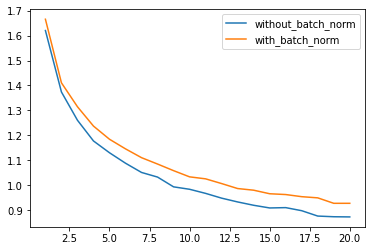

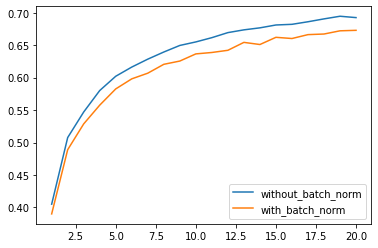

In [ ]:
compare(hist_adam, hist_adam_bn, 'without_batch_norm', 'with_batch_norm')

The results show that using batch normalization (here with dropout), model has worse performance, i.e. higher values of loss and lower accuracy

Batch Normalization allows higher learning rates.

Too high learning rates may result in the gradients that explode or vanish.   Batch  Normalization  helps address this  issue.   By  normalizing activations throughout the  network,  it prevents them from becoming too large or too small, so it helps preventing exploding/vanishing gradients, and therefore it allows higher learning rates.

source:[link text](https://arxiv.org/pdf/1502.03167.pdf)



---



### *Part* 3 b: drawing outputs of conv layers for two random photos

0 3


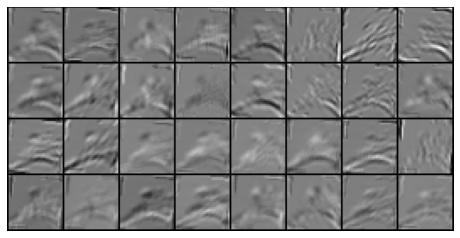

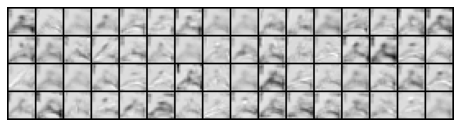

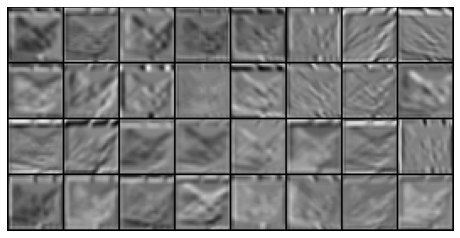

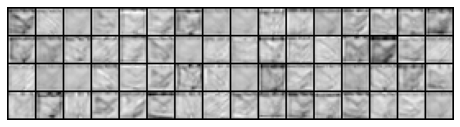

In [ ]:
random_images=np.array([X_train[30], X_train[3000]])
print(Y_train[30], Y_train[3000])
transformed_images = CIFAR10_from_array(data=random_images, label=np.array([0,1]), transform=train_transform_aug)
# loading trained model
net = Net_dropout()
net.load_state_dict(torch.load('/content/drive/My Drive/MLSec/hw2/q4/model_adam'))

for i,(x,label) in enumerate(transformed_images):
    x.unsqueeze_(0)
    conv1_out=net.conv1(x)
    x = net.dropout1(net.conv1(x))
    x = net.pool1(F.relu(x))
    conv2_out= net.conv2(x)
    visualize_tensor(conv1_out.detach(),4,8)
    visualize_tensor(conv2_out.detach(),4,16)


Here we visualized the output of first and second convolution layers for two random images using the trained model. The first photo is for an airplane and the second one is for a cat. Outputs of first layer extracted edges well, and the sketch of an airplane and a cat can be seen in the corresponding photos!

### Part 4 : Gradients

we need to make some changes to print the required gradients in even epochs


to get gradients we use [name of variable].grad

In [ ]:
def train_per_epoch_grad(model, loss_fn, dataloader, optimizer, verbose, show_grad=False): 
    #train mode
    model.train()
    
    #initialize loss
    epoch_loss = 0.0
    acc = 0.0
    train_size = 0
    
    for i, (feature, target) in enumerate(dataloader):
        #feature, target = feature.to(device), target.to(device)
        
        if torch.cuda.is_available():
            feature = feature.cuda()
            target = target.cuda()
        
        #set zero to the parameter gradients for initialization
        optimizer.zero_grad()
        feature.requires_grad=True
        output = model(feature)
        loss = loss_fn(output, target)
        
        
        #compute acc
        _, pred = torch.max(output.data, dim=1) 
        correct = (pred == target).sum().item() #convert to number
        train_size += target.size(0)
        acc += correct
        
        #compute current loss. Loss is a 0-dim tensor, so use tensor.item() to get the scalar value
        epoch_loss += loss.item()  
        
        #backward propagation
        loss.backward()
        
        #this represents one update on the weight/bias for a mini-batch(16 images in our case): 
        #weights[k] + alpha * d_weights[k]
        optimizer.step()
        
        # printing gradients
        if show_grad==True:
            print()
            print('grad w.r.t input:')
            print(feature.grad.detach())
            print('grad w.r.t conv1:')
            print(model.conv1.weight.grad.detach())
            print('grad w.r.t fc1:')
            print(model.fc1.weight.grad.detach())
            print('---------------------------------')
            
        #show the update information
        idx = i
        length = len(dataloader)
        
        #display progress
        if verbose:
            update_info(idx, length, epoch_loss, acc/train_size, '  training')
            
    acc = acc/train_size
    print('') 
    return epoch_loss/len(dataloader), acc


In [ ]:
def model_training_grad(num_epochs, model, loss_fn, train_loader, optimizer, val_loader=None, verbose=True, visualization=False):
    
    train_batch_num = len(train_loader)
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_acc'] = []
    history['val_acc'] = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        if (epoch+1)%2==0:
            print_grad=True
        else:
            print_grad=False
        train_loss, train_acc = train_per_epoch_grad(model, loss_fn, train_loader, optimizer, verbose=verbose, show_grad=print_grad)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
    
    return history


In [ ]:
num_epochs = 10
learning_rate = 0.001

net = Net_dropout(0.2)
if torch.cuda.is_available():
    net = net.cuda()
print(net)

# setting requires_grad=True to get gradients during training
for parameter in net.parameters():
    parameter.requires_grad=True
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #optimizer
#training and validating, here we set visualization=True
hist_adam_grad = model_training_grad(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True)

### Transfer Learning to Cifar-100

#### Downloading Data - Cifar-100

In [ ]:
!wget "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

--2020-12-23 10:04:42--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  31.1MB/s    in 5.8s    

2020-12-23 10:04:48 (27.7 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



In [ ]:
!tar xvzf "./cifar-100-python.tar.gz"

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


#### Preparing Data

In [ ]:
with open('./cifar-100-python/train', 'rb') as file:
    train_data= pickle.load(file, encoding='latin1')

with open('./cifar-100-python/meta', 'rb') as file:
    meta= pickle.load(file, encoding='latin1')

In [ ]:
# 5 new classes with their indices: 'bottle':9, 'butterfly':14, 'chipanzee':21, 'cup':28, 'keyboard':39
indices=[9,14,21,28,39]
indices_dict={9:0, 14:1, 21:2 ,28:3, 39:4} #labels for training should be from 0 to 5
labels=train_data['fine_labels']

X_train=np.array([train_data['data'][i] for i in range(len(labels)) if labels[i] in indices])
X_train = return_photo(X_train)
Y_train=np.array([indices_dict[labels[i]] for i in range(len(labels)) if labels[i] in indices])

In [ ]:
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),  
    transforms.RandomCrop((32, 32)),   
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

# Also use X_train in normalize since train/val sets should have same distribution
val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

trainset = CIFAR10_from_array(data=X_train_split, label=Y_train_split, transform=train_transform_aug)
valset = CIFAR10_from_array(data=X_val_split, label=Y_val_split, transform=val_transform)

batch_size = 64
num_workers = 1

train_loader_c100 = DataLoader(dataset=trainset,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=num_workers)


val_loader_c100 = DataLoader(dataset=valset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)

#### Model - Transfer Learning

In [ ]:
# Build the CNN
class Net_transfer_learning(nn.Module):
    def __init__(self, dropout=0.2, batch_norm=False):
        super(Net_transfer_learning, self).__init__()
        self.batch_norm=batch_norm
        # if batch_norm==True we add a batch normalization layer after second convolution layer and before dropout
        if batch_norm==True:
            self.batch_norm = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        #3*32*32 -> 32*32*32
        self.dropout1 = nn.Dropout(p=dropout)        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #32*32*32 -> 16*16*32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        #16*16*32 -> 16*16*64
        self.dropout2 = nn.Dropout(p=dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #16*16*64 -> 8*8*64
        self.fc1 = nn.Linear(8*8*64, 1024)
        self.dropout3 = nn.Dropout(p=dropout)

        self.fc2_c100 = nn.Linear(1024, 512)
        self.dropout4 = nn.Dropout(p=dropout)

        # changing last layer's output size to 5 instead of 10
        self.fc3_c100 = nn.Linear(512, 5)
            

    def forward(self, x):
        x = self.dropout1(self.conv1(x))
        x = self.pool1(F.relu(x))
        x = self.dropout2(self.conv2(x))
        if self.batch_norm==True:
            x=self.batch_norm(x)
        x = self.pool2(F.relu(x))
        x = x.view(-1, self.num_flat_features(x)) 
        #self.num_flat_features(x) = 8*8*64 here.
        #-1 means: get the rest a row (in this case is 16 mini-batches)
        #pytorch nn only takes mini-batch as the input
        
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2_c100(x))
        x = self.dropout4(x)
        x = self.fc3_c100(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


        
#display net architecture
print(Net_transfer_learning())

Net_transfer_learning(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2_c100): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc3_c100): Linear(in_features=512, out_features=5, bias=True)
)


#### Training two last layers while freezing others

In [ ]:
num_epochs = 50
learning_rate = 0.001
net = Net_transfer_learning(0.2)
net.load_state_dict(torch.load('/content/drive/My Drive/MLSec/hw2/q4/model_adam'), strict=False)

# we should freeze all parameters except for weights and biases of fc2_c100 and fc3_100
for parameter in net.parameters():
    parameter.requires_grad=False

net.fc2_c100.weight.requires_grad=True
net.fc2_c100.bias.requires_grad=True
net.fc3_c100.weight.requires_grad=True
net.fc3_c100.bias.requires_grad=True


# for parameter in net.parameters():
#     print(parameter.requires_grad)


if torch.cuda.is_available():
    net = net.cuda()
print(net)
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #optimizer
#training and validating, here we set visualization=True
hist_tl_1 = model_training(num_epochs, net, criterion, train_loader_c100, optimizer, val_loader_c100, verbose=True)


In [ ]:
hist_save('', hist_tl_1)
torch.save(net.state_dict(), '/content/drive/My Drive/MLSec/hw2/q4/model_tl_1')

#### Training all layers

In [ ]:
num_epochs = 50
learning_rate = 0.001
net = Net_transfer_learning(0.2)
net.load_state_dict(torch.load('/content/drive/My Drive/MLSec/hw2/q4/model_adam'), strict=False)

# here we set requires_grad for all parameters True
for parameter in net.parameters():
    parameter.requires_grad=True


if torch.cuda.is_available():
    net = net.cuda()
print(net)
print('=================================================================')

criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #optimizer
#training and validating, here we set visualization=True
hist_tl_2 = model_training(num_epochs, net, criterion, train_loader_c100, optimizer, val_loader_c100, verbose=True)


In [ ]:
hist_save('', hist_tl_2)
torch.save(net.state_dict(), '/content/drive/My Drive/MLSec/hw2/q4/model_tl_2')

#### Comparing two methods




compare two methods


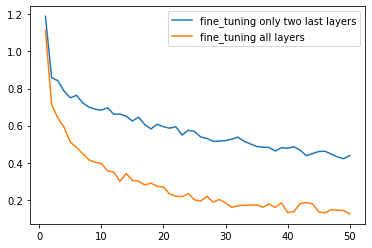

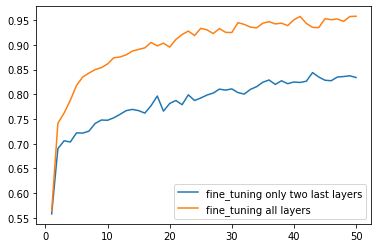

In [ ]:
print('compare two methods')
compare(hist_tl_1, hist_tl_2, 'fine_tuning only two last layers', 'fine_tuning all layers')

As illustrated by the results, the performace is much better when we fine tune all layers for the new dataset